In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os.path
import pickle
from itertools import takewhile
from PIL import Image

import nltk
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from datasets.flickr8k_new import Flickr8kDataset
from datasets.coco import CoCoDataloader
from glove import embedding_matrix_creator
from metrics import bleu_score_fn, accuracy_fn 
from utils_torch import (
    words_from_tensors_fn,
    check_create_dir, 
    get_picture_caption,
)
from train_torch import train_model, evaluate_model
from tqdm.auto import tqdm

nltk.download('punkt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


[nltk_data] Downloading package punkt to /Users/olya-
[nltk_data]     const/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/olya-
[nltk_data]     const/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Define train/validation/test Datasets & get the vocabulary:

In [6]:
DATASET_BASE_PATH = 'data/flickr8k/'
VOCAB = 'vocab_set.pkl'

train_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train',
    device=device, return_type='tensor', load_img_to_memory=False,
)
vocab_set = train_set.get_vocab()
with open(VOCAB, 'wb') as f:
    pickle.dump(vocab_set, f)
vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)

val_set_loss = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='valloss',  vocab_set=vocab_set,
    device=device, return_type='tensor', load_img_to_memory=False
)

val_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False
)

test_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False
)

train_eval_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False
)

print(
    f"The number of samples in:\ntrain: {len(train_set)};"
    + f" validation: {len(val_set)}; test: {len(test_set)}\n"
    + f"Vocabulary size: {vocab_size}; Max length of a sentence: {max_len};"
)

The number of samples in:
train: 30000; validation: 1000; test: 1000
Vocabulary size: 7708; Max length of a sentence: 40;


# Define the experiment parameters:

#### Note: you can use:
    model_name = densenet161_lstm
    model_name = vgg16_lstm

#### Probably you can add the other models as well and use the notebook, but check!

In [7]:
model_name = "vgg16_lstm" # change me:)

if model_name == "vgg16_lstm":
    from models.torch.vgg16_lstm import Captioner
    embedding_dim = 50
    embedding_desc = f"GLV{embedding_dim}"
    hidden_size = 256
    learning_rate = 1e-2
    num_layers = 1
    train_embd = False
    idx_range = [0, 2, 3, 12, 40]
    dset = train_eval_set
    n_epochs = 3
    batch_size = 32

elif model_name == "densenet161_lstm":
    from models.torch.densenet161_lstm import Captioner
    embedding_dim = 50
    embedding_desc = f"GLV{embedding_dim}"
    hidden_size = 256
    learning_rate = 1e-2
    num_layers = 2
    train_embd = False
    idx_range = [0, 2, 3, 12, 40]
    dset = train_eval_set
    n_epochs = 69
    batch_size = 16
else:
    assert False, f"Bad name of the model: {model_name}"

# Define Data Transformations & Dataloaders:

In [8]:
train_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.RandomCrop(224),  # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(224),  # get 224x224 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

train_set.transformations = train_transformations
val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations
val_set_loss.transformations = eval_transformations

eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, sampler=None, pin_memory=False,
)

val_loader_loss = DataLoader(
    val_set_loss, batch_size=batch_size, shuffle=True, sampler=None, pin_memory=False,
)

val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, sampler=None, pin_memory=False, collate_fn=eval_collate_fn,
)

test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, sampler=None, pin_memory=False, collate_fn=eval_collate_fn,
)

train_eval_loader = DataLoader(
    train_eval_set, batch_size=batch_size, shuffle=False, sampler=None, pin_memory=False, collate_fn=eval_collate_fn,
)

# Define a model, loss, metric, optimizer, embedding_matrix:

In [ ]:
embedding_matrix = embedding_matrix_creator(
    embedding_dim=embedding_dim,
    word2idx=word2idx,
)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

model = Captioner(
    embedding_dim,
    hidden_size,
    vocab_size,
    num_layers=num_layers,
    embedding_matrix=embedding_matrix,
    train_embd=train_embd
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(
    ignore_index=train_set.pad_value
).to(device)
acc_fn = accuracy_fn(ignore_value=train_set.pad_value)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(
    idx2word=idx2word
)

params = (
    list(model.decoder.parameters())
    + list(model.encoder.embed.parameters())
    + list(model.encoder.bn.parameters())
)

optimizer = torch.optim.Adam(
    params=params,
    lr=learning_rate,
)

# Main training cycle:

**Note:** modify train_from_scratch=True if you want to get your model!

In [11]:
train_from_scratch = False

if train_from_scratch:
    check_create_dir(f'saved_models/{model_name}')
    save_path = f'saved_models/{model_name}/{model_name}_b{batch_size}_emd{embedding_dim}'
    print(save_path)

    save_file_name = f'saved_models/{model_name}/{model_name}_b{batch_size}_emd{embedding_dim}.txt'

    train_loss_min = 100
    val_bleu4_max = 0.0

    for epoch in range(n_epochs):
        train_loss = train_model(
            desc=f'Epoch {epoch + 1}/{n_epochs}',
            model=model,                                                                      
            optimizer=optimizer,
            loss_fn=loss_fn,                                          
            train_loader=train_loader
        )

        with torch.no_grad():
            train_bleu = evaluate_model(
                desc=f'\tTrain Bleu Score: ',
                model=model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=train_eval_loader
            )

            val_bleu = evaluate_model(
                desc=f'\tValidation Bleu Score: ',
                model=model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=val_loader
            )

            print(f'Epoch {epoch + 1}/{n_epochs}',
                ''.join([f'train_bleu{i}: {train_bleu[i]:.4f} ' for i in (1, 4)]),
                ''.join([f'val_bleu{i}: {val_bleu[i]:.4f} ' for i in (1, 4)]),
                )

    
            im, cp, _ = train_eval_set[4000]
            capidx = model.sample(im.unsqueeze(0))[0].detach().cpu().numpy()
            print(train_eval_set.get_image_captions(4000)[1][0])
            caption_pred=''.join(list(takewhile(lambda word: word.strip() != '<end>',
                                                                    map(lambda idx: idx2word[idx]+' ', iter(capidx))))[1:])
            print(f'greedy:', caption_pred)
            
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss_latest': train_loss,
                'val_bleu4_latest': val_bleu[4],
                'train_loss_min': min(train_loss, train_loss_min),
                'val_bleu4_max': max(val_bleu[4], val_bleu4_max),
                'train_bleus': train_bleu,
                'val_bleus': val_bleu,
            }

            if train_loss < train_loss_min:
                train_loss_min = train_loss
                torch.save(state, f'{save_path}_best_train.pt')
                
            if val_bleu[4] > val_bleu4_max:
                val_bleu4_max = val_bleu[4]
                torch.save(state, f'{save_path}_best_val.pt')

            if (epoch + 1) % 20 == 0:
                torch.save(state, f'{save_path}_ep{epoch + 1}.pt')

            with open(save_file_name, "a") as f:
                f.write(
                    f"ep:{epoch};tr_loss:{train_loss:.3f};" 
                    + f"tr_bleu1:{train_bleu[1]:.3f};v_blue1:{val_bleu[1]:.3f};"
                    + f"gen_capture_greedy:{caption_pred};\n"
                )

# Get predefined checkpoint:

In [ ]:
if not train_from_scratch:
    MODEL_DIR = './'
    MODEL_NAME = f'{model_name}_b{batch_size}_emd{embedding_desc}_best_val.pt'
    
    if model_name == "vgg16_lstm":
        !gdown 1_e4xb1BZuh_aS7171BRQm7FipbgqJJoz
    
    elif model_name == "densenet161_lstm":
        !gdown 1CLODHygvcd9Lfczy5bsUT656OkXOTvUG
    
    checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME), map_location=torch.device('cpu'))
    !rm $MODEL_NAME 

    # define the model:
    model = Captioner(
        embedding_dim,
        hidden_size,
        vocab_size,
        num_layers=num_layers,
        embedding_matrix=embedding_matrix,
        train_embd=train_embd
    ).to(device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

# Evaluate on Flickr8k:

In [9]:
inter_params = {
    'model': model,
    'bleu_score_fn': corpus_bleu_score_fn,
    'tensor_to_word_fn': tensor_to_word_fn,
}

with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(
        desc=f'Train: ',
        data_loader=train_eval_loader,
        **inter_params,
    )
    
    val_bleu = evaluate_model(
        desc=f'Val: ',
        data_loader=val_loader,
        **inter_params,
    )
    
    test_bleu = evaluate_model(
        desc=f'Test: ',
        data_loader=test_loader,
        **inter_params,
    )
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}\n', end=' ')
        print()

Test: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s, bleu1=0.554, bleu4=0.133]

train Bleu-1: 0.5553483525466868
 Bleu-2: 0.3494481583922505
 Bleu-3: 0.2194906074925282
 Bleu-4: 0.14028907400244292
 
val Bleu-1: 0.5514167288420477
 Bleu-2: 0.3442626791832862
 Bleu-3: 0.2136541242536706
 Bleu-4: 0.13471826777159288
 
test Bleu-1: 0.5541791565345384
 Bleu-2: 0.34341787406203406
 Bleu-3: 0.21134767136240631
 Bleu-4: 0.13291320346350355
 


# Generate captions:

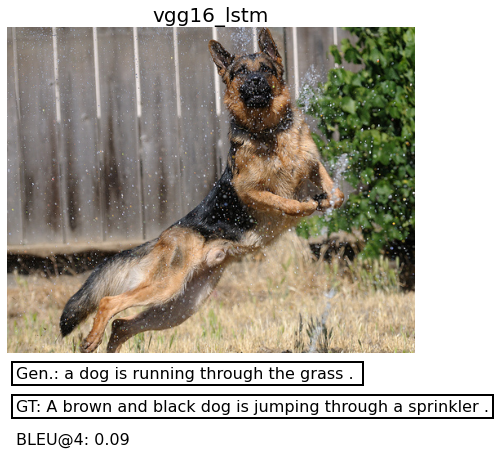

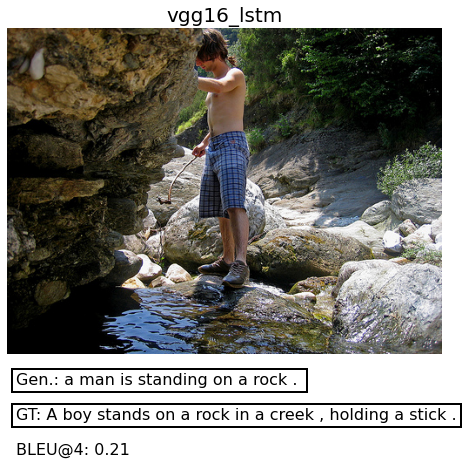

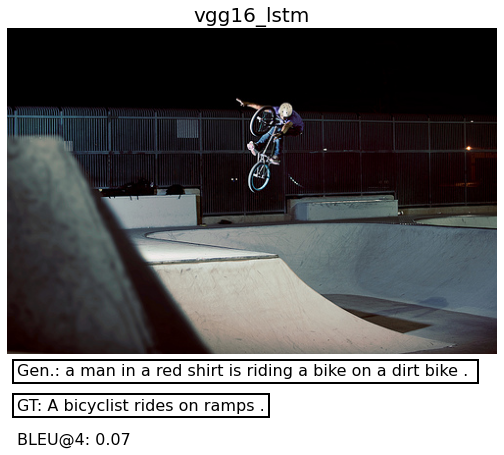

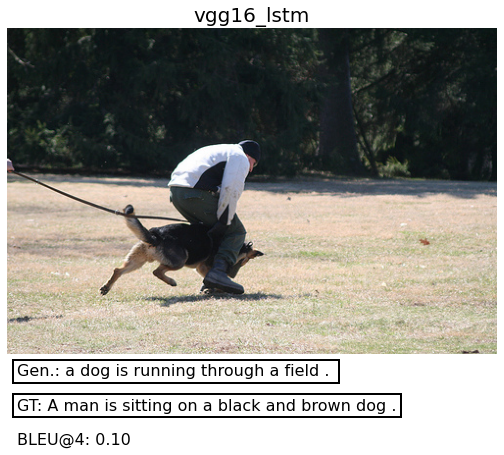

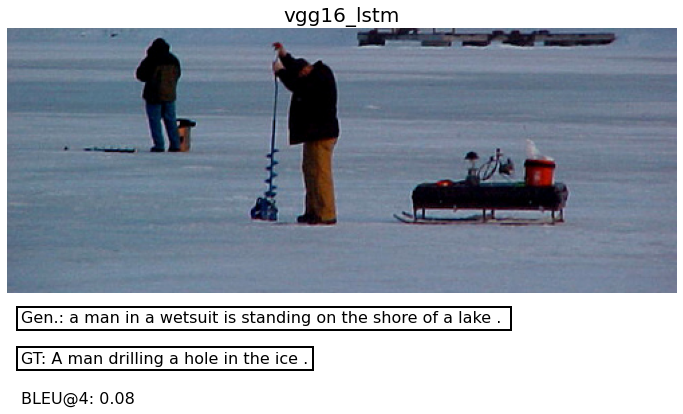

In [18]:
spatial = (
    ((10, 430), (10, 470), (10, 510)),
    ((10, 410), (10, 450), (10, 490)),
    ((10, 355), (10, 390), (10, 425)),
    ((10, 355), (10, 390), (10, 425)),
    ((10, 220), (10, 250), (10, 280)),
)

idx2spatial = {i:v for i, v in zip(idx_range, spatial)}

for idx in idx2spatial:
    x1_y1, x2_y2, x3_y3 = idx2spatial[idx]
    generated_caption = get_picture_caption(idx, dset, model, idx2word)
    score = f"BLEU@4: {bleu_score_fn(4, 'corpus')([[i.split() for i in dset.get_image_captions(idx)[1]]], [generated_caption.split()], n=4):0.2f}"
    img = Image.open(dset.get_image_captions(idx)[0])
    plt.figure(figsize=(12, 6), facecolor="white")
    plt.imshow(img)
    plt.axis('off')
    plt.title(model_name, fontsize=20)
    plt.text(
        *x1_y1, "Gen.: " + generated_caption,
        fontsize=16, bbox=dict(fill=False, edgecolor='black', linewidth=2)
    )
    plt.text(
        *x2_y2, "GT: " + dset.get_image_captions(idx)[1][0],
        fontsize=16, bbox=dict(fill=False, edgecolor='black', linewidth=2)
    )
    plt.text(
        *x3_y3, score,
        fontsize=16,
    )
    plt.show();

# Check quality on COCO dataset:

In [19]:
vocab_from_file = True # if True, load existing vocab file
split_size = 1 # 1 means the whole data

coco_val_loader = CoCoDataloader(
    transform=eval_transformations,
    batch_size=batch_size,
    vocab_from_file=vocab_from_file,
    vocab_file='./vocab_set.pkl',
    size=split_size,
    img_folder='data/coco/val2014',
    annotations_file='data/coco/annotations/captions_val2014.json',
    shuffle=True,
    random_seed=42,
)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:12<00:00, 16748.46it/s]


In [20]:
def evaluate_model_coco(data_loader, model, data, bleu_score_fn, tensor_to_word_fn, desc=''):
    running_bleu = [0.0] * 5
    model.eval()
    t = tqdm(iter(data_loader), desc=f'{desc}')
    for batch_idx, batch in enumerate(t):
        if data=='coco':
            images, caption_list = batch
            captions = []
            for caption in caption_list:
              toks = nltk.word_tokenize(caption.lower())
              captions.append([toks])       
            images = images.to(device)
        else:
            images, captions, _ = batch
        
        outputs = tensor_to_word_fn(model.sample(images).cpu().numpy())

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(captions, outputs, n=i)
        t.set_postfix({
            'bleu1': running_bleu[1] / (batch_idx + 1),
            'bleu4': running_bleu[4] / (batch_idx + 1),
        }, refresh=True)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(data_loader)
    return running_bleu

In [21]:
with torch.no_grad():
    val_bleu = evaluate_model_coco(
        desc=f'\tValidation Bleu Score: ',
        model=model,
        data='coco',
        bleu_score_fn=corpus_bleu_score_fn,
        tensor_to_word_fn=tensor_to_word_fn,
        data_loader=coco_val_loader,
    )
    print()
    print('val', end=' ')
    for ngram in (1, 2, 3, 4):
        print(f'Bleu-{ngram}: {val_bleu[ngram]}', end=' ')
    print()

	Validation Bleu Score: 100%|██████████| 6333/6333 [15:11<00:00,  6.95it/s, bleu1=0.26, bleu4=0.0221]


val Bleu-1: 0.2604302975904611 Bleu-2: 0.09956270791860876 Bleu-3: 0.04160820218797995 Bleu-4: 0.022092987372293406 
